<a href="https://colab.research.google.com/github/YoishD/Data-Science-B7/blob/main/YeshDakpU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import xarray as xr
!pip install bambi
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import bambi as bmb
!pip install graphviz
import graphviz as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.0 MB/s eta 0:00:00


I chose this data set mainly cause I couldn't really find anything else. I am just gonna try to model the power consumption of Tetuan using Temperature, humiditiy, and diffuse flow. Under the idea that people will stay inside and those use more electricity when these values are high. I am not going to be focusing on specific zones right now, I'll figure out which zone I want to focus on later or maybe I'll do all of them, I am not sure right now. Another thing is that I am aware that specific days might warrant higher electricity ususage, like a city wide festival, however I am just unsure how to add it into this model so I am leaving that unattended to. I also feel that wind speed doesn't really tell us any more information than temperature, so I am also leaving that out for now.

Note: Diffuse flow, are "uniform shallow flow that is conveyed to a vegetated filter strip, another ground surface or stormwater practice," according to the North Carolina Dept. of Environmental Quality. So basically its just a measure of runoff rainwater. The idea being that people don't go outside when it rains. I actually have no clue what the difference is between Diffuse flow and general diffuse flow is, as I am getting really different answers online, so I am just gonna stick with the normal diffuse flow.

In [2]:
powerC = pd.read_csv('https://raw.githubusercontent.com/YoishD/Data-Science-B7/refs/heads/main/Tetuan%20City%20power%20consumption.csv')
powerC
# This is way to big I am gonna need to use a random sample for this to continue

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [3]:
powerC = powerC.rename({'Zone 1 Power Consumption': 'Z1', 'Zone 2  Power Consumption': 'Z2', 'Zone 3  Power Consumption': 'Z3', 'diffuse flows':'df', 'Wind Speed':'ws'}, axis=1)

In [4]:
powerCr = powerC.sample(n=2000)
#I am going to use this to set a min and max for my knots
a = powerCr['Temperature'].max()
b = powerCr['Temperature'].min()
c = powerCr['Humidity'].max()
d = powerCr['Humidity'].min()
e = powerCr['ws'].max()
f = powerCr['ws'].min()

I have an assumption on how Df effects power consumption but I am not entirely sure, so I am just gonna see how it actually effects power consumption across all three zones.

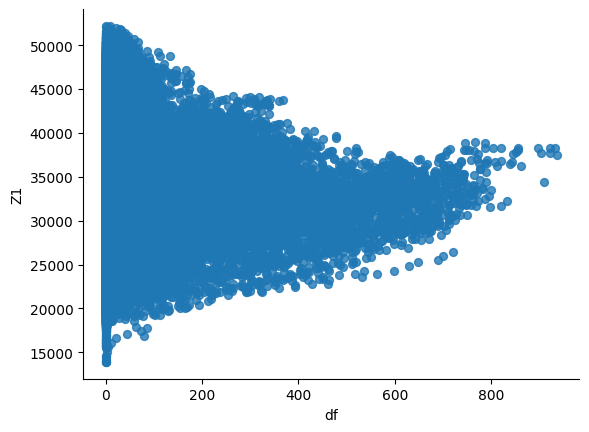

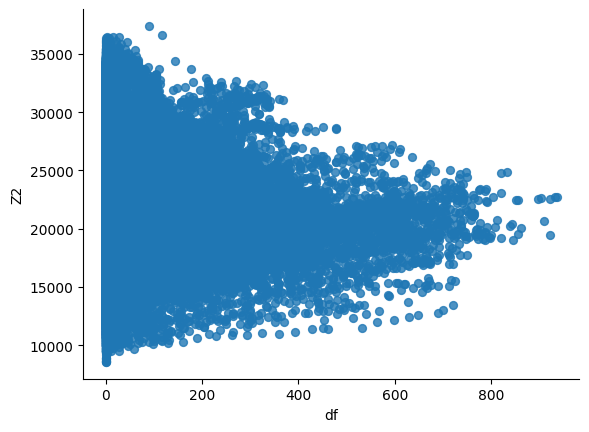

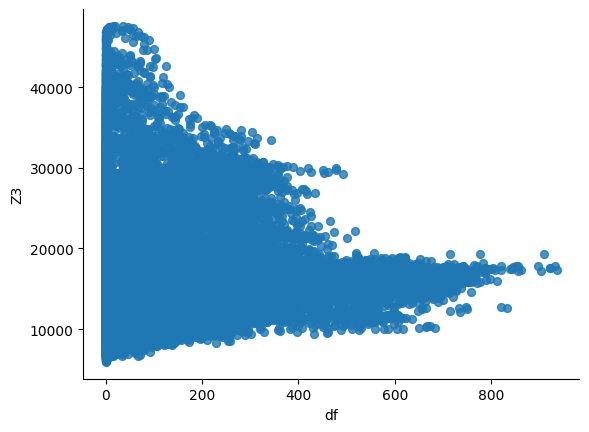

In [ ]:
powerC.plot(kind='scatter', x='df', y='Z1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
powerC.plot(kind='scatter', x='df', y='Z2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
powerC.plot(kind='scatter', x='df', y='Z3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

I am so confused. It doesnt look random, infact it seems as df gets lower it increases, but their is just so much spread at 0, that I can't really pinpoint any specfic trends. So I am just going to remove it an add Wind speed as a replacement cause then at least I am able to gleam more off of temperature.

In [ ]:
powerCr.columns

Index(['DateTime', 'Temperature', 'Humidity', 'ws', 'general diffuse flows',
       'df', 'Z1', 'Z2', 'Z3'],
      dtype='object')

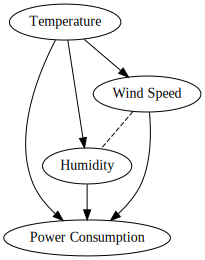

In [ ]:
g = gr.Digraph()
g.node(name="x1", label="Power Consumption")
g.node(name="x2", label="Temperature")
g.node(name="x3", label="Humidity")
g.node(name="x4", label="Wind Speed")

#Power Consumption
g.edge(tail_name="x2", head_name="x1")
g.edge(tail_name="x3", head_name="x1")
g.edge(tail_name="x4", head_name="x1")
#Humidity
g.edge(tail_name="x2", head_name="x3")
g.edge(tail_name="x4", head_name="x3",style="dashed", dir="none")
#Temperature
g.edge(tail_name="x2", head_name="x4")

g

Based off of this causual model, we can clearly see that no matter what our Temperature will have the greatest impact. Wind speeds actually should have a negative relationship between Temperature and humidity, as lower temps are more coorelated with higher wind speeds, and thus also lead to less evaporation and less humidity.

In [5]:
num_knots = 6
knotst = np.linspace(b, a, num_knots+2)[1:-1]
knotsh = np.linspace(d, c, num_knots+2)[1:-1]
knotsw = np.linspace(f, e, num_knots+2)[1:-1]

model_spline_t = bmb.Model("'Z1' ~ bs(Temperature, degree=2, knots=knotst) +bs(Humidity, degree=2, knots=knotsh) + bs(ws, degree=2, knots=knotsw)", powerCr, family="negativebinomial")
idata_spline_t = model_spline_t.fit()
#I dont know how to add interactions. I am going to first run all my zones then try to figure out how to increase my models accuracy
#My code doesn't like having more than 1 degree for humidity and ws, I'm not sure why but I do think its something to look into

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


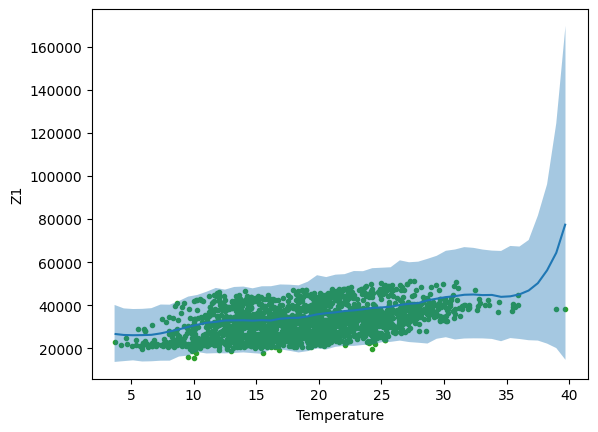

In [6]:
bmb.interpret.plot_predictions(model_spline_t, idata_spline_t, ["Temperature"], pps= True)
plt.plot(powerCr.Temperature, powerCr['Z1'], "C2.", zorder=-3)

<Axes: xlabel='Z1'>

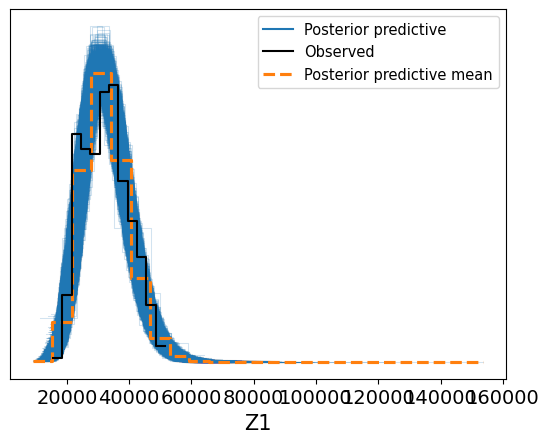

In [8]:
model_spline_t.predict(idata_spline_t, kind='response')
az.plot_ppc(idata_spline_t)

Okay so lets talk about the positives first. We do capture all of our data and our mean line actually does follow the general trend of our data. Our Hdi is actually pretty accurate for the bulk of our data but the problem is that it kinda fails badly at the really high extremes and I might actually be over fitting our data. I am gonna run this code for the other zones and see if I can see any more problems across the three zones

It is just a blob. So we can't really change this large hdi because then we aren't really representative of all of our data, just this sample of it. What I now want to do is first model this for all my other zones to see if this general trend stays true, then try to figure out any way I can add in the interactions with my model

In [24]:
num_knots = 6
knotst = np.linspace(b, a, num_knots+2)[1:-1]
knotsh = np.linspace(d, c, num_knots+2)[1:-1]
knotsw = np.linspace(f, e, num_knots+2)[1:-1]

model_spline_ttwo = bmb.Model("'Z2' ~ bs(Temperature, degree=2, knots=knotst) +bs(Humidity, degree=2, knots=knotsh) + bs(ws, degree=2, knots=knotsw) ", powerCr, family="negativebinomial")
idata_spline_ttwo = model_spline_ttwo.fit()


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


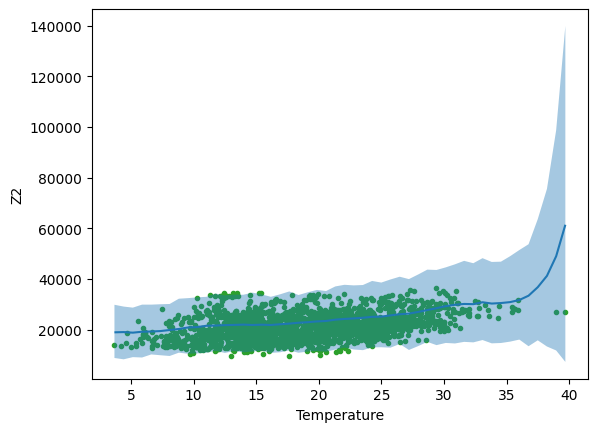

In [25]:
bmb.interpret.plot_predictions(model_spline_ttwo, idata_spline_ttwo, ["Temperature"], pps= True)
plt.plot(powerCr.Temperature, powerCr['Z2'], "C2.", zorder=-3)

<Axes: xlabel='Z2'>

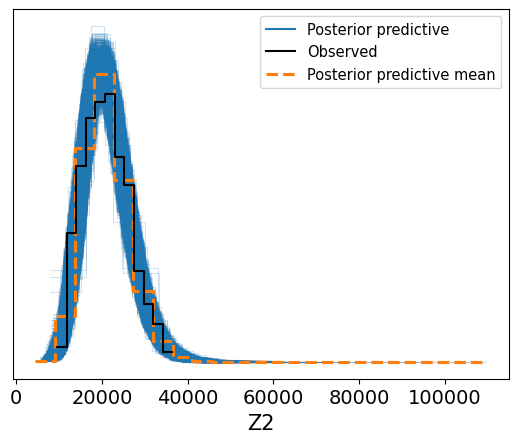

In [26]:
model_spline_ttwo.predict(idata_spline_ttwo, kind='response')
az.plot_ppc(idata_spline_ttwo)

So same problems with Zone 1 Model, and very similar trends, nothing to new here

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


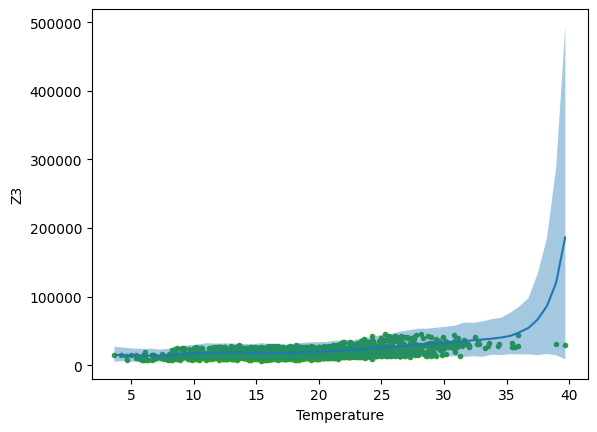

In [28]:
num_knots = 6
knotst = np.linspace(b, a, num_knots+2)[1:-1]
knotsh = np.linspace(d, c, num_knots+2)[1:-1]
knotsw = np.linspace(f, e, num_knots+2)[1:-1]

model_spline_tthree = bmb.Model("'Z3' ~ bs(Temperature, degree=2, knots=knotst) +bs(Humidity, degree=2, knots=knotsh) + bs(ws, degree=2, knots=knotsw) ", powerCr, family="negativebinomial")
idata_spline_tthree = model_spline_tthree.fit()
bmb.interpret.plot_predictions(model_spline_tthree, idata_spline_tthree, ["Temperature"], pps= True)
plt.plot(powerCr.Temperature, powerCr['Z3'], "C2.", zorder=-3)

<Axes: xlabel='Z3'>

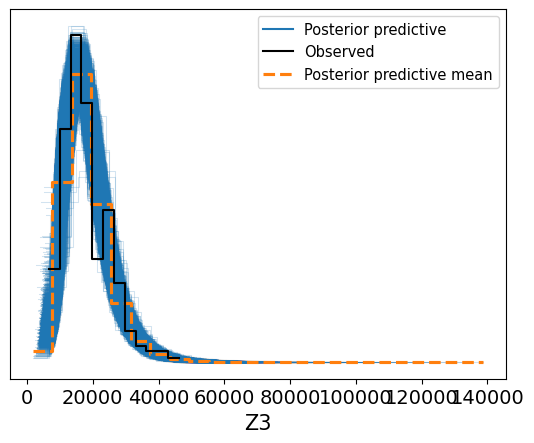

In [29]:
model_spline_tthree.predict(idata_spline_tthree, kind='response')
az.plot_ppc(idata_spline_tthree)

So nothing really big changes across all three zones, and all graphs show case similar trends. I guess the next step now would be to either to try in add interactions or try to reduce that large hdi at the end. However today is the last day so I don't really have any extra time. I did though did some diggin on the data set and its origins, and learned that it came from this [study](https://ieeexplore.ieee.org/document/8703007), about trying to figure out which ML algorithm is best for modeling power consumption.

In it does clarify what the zones and diffuse flows actually refer to in context. Diffuse Flow is "is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna," and the different zones are actually just power consumption from from threee different power distribution networks in Tetouan city. But the more important thing to gleam from this is that I probably should have used a GP to model this instead of just using b-spline, and that would have helped cut down all that uncertainity near the end of the graphs. But overall I think I did what I was settings out to do, and it seems that the model is pretty consisnent across all the different "zones"